In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
from diffusers import DDIMScheduler
from data.src.local_sd_pipeline import LocalStableDiffusionPipeline
import torch
import matplotlib.pyplot as plt
import math

/home/ubuntu/miniforge3/envs/diffusion/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set up the Stable Diffusion pipeline
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = LocalStableDiffusionPipeline.from_pretrained(
        model_id,
        safety_checker=None,
        requires_safety_checkers=None,
        torch_dtype=torch.float32
    )
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)

Keyword arguments {'requires_safety_checkers': None} are not expected by LocalStableDiffusionPipeline and will be ignored.
Loading pipeline components...:  33%|███▎      | 2/6 [00:00<00:00,  6.94it/s]

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 14.66it/s]
You have disabled the safety checker for <class 'data.src.local_sd_pipeline.LocalStableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [49]:
PROMPT = "Mothers influence on her young hippo"

In [60]:
AUG_IMAGES = 4
SEED = 42

aug_generator = torch.Generator(device=device).manual_seed(SEED)
auged_prompt_embeds = pipe.aug_prompt(
        PROMPT,
        num_images_per_prompt=AUG_IMAGES,
        target_steps=[0],
        lr=0.02,
        optim_iters=15,
        target_loss=1.8,
        print_optim=True,
        generator=aug_generator
)

  0%|          | 0/50 [00:00<?, ?it/s]

step: 0, curr loss: 15.590296745300293
step: 1, curr loss: 14.830482482910156
step: 2, curr loss: 14.070289611816406
step: 3, curr loss: 13.248230934143066
step: 4, curr loss: 12.25889778137207
step: 5, curr loss: 10.693195343017578
step: 6, curr loss: 7.9035115242004395
step: 7, curr loss: 5.448620796203613
step: 8, curr loss: 3.920180082321167
step: 9, curr loss: 2.1261534690856934


  0%|          | 0/50 [00:14<?, ?it/s]

step: 10, curr loss: 1.7965739965438843


  4%|▍         | 2/50 [00:00<00:18,  2.60it/s]

100%|██████████| 50/50 [00:19<00:00,  2.63it/s]


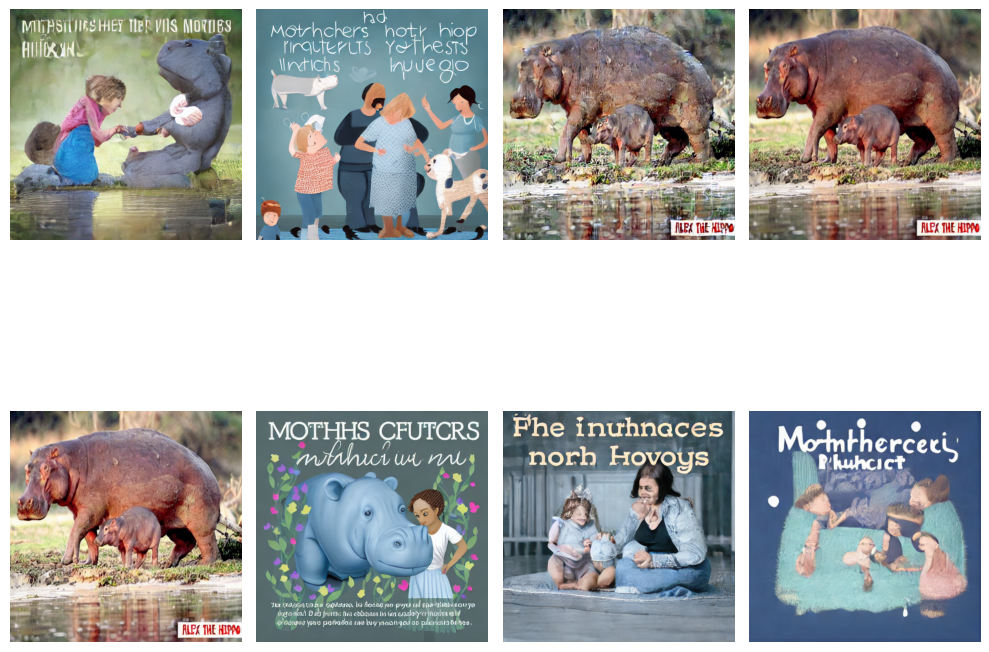

In [61]:
BATCH_SIZE = 8

# Generate images
with torch.autocast("cuda"):
    images = pipe(prompt_embeds=auged_prompt_embeds,
              num_images_per_prompt=BATCH_SIZE).images

# Calculate the number of rows and columns for the grid
num_rows = int(math.sqrt(BATCH_SIZE))
num_cols = math.ceil(BATCH_SIZE / num_rows)

# Display the generated images in a grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
axs = axs.flatten()

for i, img in enumerate(images):
    axs[i].imshow(img)
    axs[i].axis('off')

# Remove any unused subplots
for i in range(len(images), num_rows * num_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()